## <p style="background-color:#757D70;color:#D5CABD;font-size:110%;text-align:center;border-radius:20px 60px;  border: 10px solid #cfcfcf;  padding-top: 10px;  padding-left: 10px;  padding-right: 10px; padding-bottom: 10px;  border-radius: 80px 20px;line-height: 1.2em; margin-bottom: 10px;"> Projet de Data Mining : Segmentation </p>

## Importations des bibliothèques utiles

In [59]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import plotly
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode
import plotly.express as px
import plotly.graph_objects as go
import scipy
from scipy import stats
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
import sklearn 
from sklearn import decomposition,cluster
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score,davies_bouldin_score,homogeneity_score 
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator
from sklearn.model_selection import ParameterGrid
from sklearn.metrics.cluster import adjusted_rand_score
import statistics

import sys
import time
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 100)

In [60]:
#Chargement des données
base = pd.read_csv("donnees_ecommerce.csv", encoding='ISO-8859-1')

In [61]:
base.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
25981,538449,82582,AREA PATROLLED METAL SIGN,3,12/12/2010 12:24,2.10,17085.0,United Kingdom
287220,562096,23198,PANTRY MAGNETIC SHOPPING LIST,2,8/2/2011 13:16,1.45,15311.0,United Kingdom
211752,555397,22178,VICTORIAN GLASS HANGING T-LIGHT,9,6/2/2011 17:26,2.46,NaN,United Kingdom
500508,578783,21739,COSY SLIPPER SHOES SMALL GREEN,1,11/25/2011 11:58,2.95,12748.0,United Kingdom
235902,C557653,20725,LUNCH BAG RED RETROSPOT,-1,6/21/2011 17:25,1.65,14040.0,United Kingdom


## Fonction EDA

In [62]:
# Récupération du nom de la variable
def get_dataset_name(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

# Fonctions statistiques
def nb_col(base): return base.shape[1]
def nb_lignes(base): return base.shape[0]
def nb_val_manquante(base): return base.isna().sum().sum()
def freq_val_manquante(base): return base.isna().sum().sum() / base.size
def nb_lignes_dupliq(base): return base.duplicated().sum()
def freq_lignes_dupliq(base): return base.duplicated().mean()
def nb_lignes_vide(base): return base.isna().all(axis=1).sum()
def freq_lignes_vide(base): return base.isna().all(axis=1).mean()
def nb_col_vide(base): return base.isna().all().sum()
def freq_col_vide(base): return base.isna().all().mean()
def nb_col_nom_dupliq(base): return base.columns.duplicated().sum()

def nb_col_dupliq(base):
    duplicate_names = set()
    for i in range(base.shape[1]):
        for j in range(i + 1, base.shape[1]):
            if base.iloc[:, i].equals(base.iloc[:, j]):
                duplicate_names.add(base.columns[j])
    return len(duplicate_names)

# Fonction globale d’affichage
def stat_globale(base):
    print(f'Données : {get_dataset_name(base, globals())}')
    print(f'Nombre de variables : {nb_col(base)}')
    print(f'Nombre des observations : {nb_lignes(base)}')
    print(f'Nombre de valeurs manquantes : {nb_val_manquante(base)}')
    print(f'% valeurs manquantes : {freq_val_manquante(base):.2%}')
    print(f'Nombre de lignes dupliquées : {nb_lignes_dupliq(base)}')
    print(f'% de lignes dupliquées : {freq_lignes_dupliq(base):.2%}')
    print(f'Nombre de lignes vides : {nb_lignes_vide(base)}')
    print(f'% de lignes vides : {freq_lignes_vide(base):.2%}')
    print(f'Nombre de Colonnes vides : {nb_col_vide(base)}')
    print(f'% de colonnes vides : {freq_col_vide(base):.2%}')
    print(f'Nombre de Colonnes ayant le même nom : {nb_col_nom_dupliq(base)}')
    print(f'Nombre de Colonnes dupliquées : {nb_col_dupliq(base)}')


In [63]:
stat_globale(base)

Données : ['base']
Nombre de variables : 8
Nombre des observations : 541909
Nombre de valeurs manquantes : 136534
% valeurs manquantes : 3.15%
Nombre de lignes dupliquées : 5268
% de lignes dupliquées : 0.97%
Nombre de lignes vides : 0
% de lignes vides : 0.00%
Nombre de Colonnes vides : 0
% de colonnes vides : 0.00%
Nombre de Colonnes ayant le même nom : 0
Nombre de Colonnes dupliquées : 0


In [64]:
# Nettoyage
base.dropna(subset=["CustomerID"], inplace=True)
base = base[base["Quantity"] > 0]
base["TotalPrice"] = base["Quantity"] * base["UnitPrice"]
base.set_index('InvoiceNo', inplace=True)

In [65]:
# Transformation des dates
base["InvoiceDate"] = pd.to_datetime(base["InvoiceDate"])

In [66]:
# Dernière date d'achat dans le jeu de données
snapshot_date = base["InvoiceDate"].max()

In [67]:
base.dtypes

StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
TotalPrice            float64
dtype: object

## Conversion en category

In [68]:
# Identification des colonnes de type object
colonnes_objet = [col for col in base.columns if base[col].dtype == 'object']

# Conversion en type category
for col in colonnes_objet:
    base[col] = base[col].astype('category')

# Vérification
colonnes_categorique = [col for col in base.columns if base[col].dtype.name == 'category']
print(colonnes_categorique)


['StockCode', 'Description', 'Country']


In [69]:
colonnes_numeriques = [col for col in base.columns if pd.api.types.is_numeric_dtype(base[col])]
print(colonnes_numeriques)

['Quantity', 'UnitPrice', 'CustomerID', 'TotalPrice']


In [70]:
numerical = ['Quantity', 'UnitPrice', 'CustomerID', 'TotalPrice']

## Stantdardisation des données

In [71]:
# Création d'une copie standardisée des colonnes numériques
scaler = StandardScaler()
base_scaled = pd.DataFrame(scaler.fit_transform(base[numerical]), columns=numerical, index=base.index)
base=base_scaled

In [74]:
base

,Quantity,UnitPrice,CustomerID,TotalPrice
InvoiceNo,,,,
536365,-0.038919,-0.025623,1.491789,-0.022956
536365,-0.038919,0.012392,1.491789,-0.006648
536365,-0.027834,-0.016571,1.491789,-0.001277
536365,-0.038919,0.012392,1.491789,-0.006648
536365,-0.038919,0.012392,1.491789,-0.006648
...,...,...,...,...
581587,-0.005664,-0.102557,-1.526012,-0.039458
581587,-0.038919,-0.045987,-1.526012,-0.031693
581587,-0.050005,0.046786,-1.526012,-0.018750


## Analyse en composante

In [39]:
def display_correlation_circle(pcs, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < pcs.shape[0]:
            fig, ax = plt.subplots(figsize=(7, 7))

            # Limites
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax = pcs[d1, :].min(), pcs[d1, :].max()
                ymin, ymax = pcs[d2, :].min(), pcs[d2, :].max()

            # Flèches
            if pcs.shape[1] < 30:
                ax.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                          pcs[d1, :], pcs[d2, :], angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0, 0], [x, y]] for x, y in pcs[[d1, d2]].T]
                ax.add_collection(LineCollection(lines, color='black', alpha=0.1))

            # Labels
            if labels is not None:
                for i, (x, y) in enumerate(pcs[[d1, d2]].T):
                    if xmin <= x <= xmax and ymin <= y <= ymax:
                        ax.text(x, y, labels[i], fontsize=12, ha='center', va='center',
                                rotation=label_rotation, alpha=0.6)

            # Cercle
            circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='blue')
            ax.add_artist(circle)

            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)
            ax.axhline(0, color='grey', linestyle='--')
            ax.axvline(0, color='grey', linestyle='--')

            ax.set_xlabel(f"F{d1+1} ({round(100 * pca.explained_variance_ratio_[d1], 1)}%)")
            ax.set_ylabel(f"F{d2+1} ({round(100 * pca.explained_variance_ratio_[d2], 1)}%)")
            ax.set_title(f"Cercle des corrélations (F{d1+1} et F{d2+1})")
            ax.grid(True)
            ax.set_aspect('equal', 'box')
            plt.show()

def display_factorial_planes(X_projected, pca, axis_ranks, labels=None, illustrative_var=None, colors=None, alpha=1, size=20):
    for d1, d2 in axis_ranks:
        if d2 < X_projected.shape[1]:
            fig, ax = plt.subplots(figsize=(7, 6))

            if illustrative_var is None:
                ax.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha, s=size)
            else:
                illustrative_var = np.array(illustrative_var)
                unique_values = np.unique(illustrative_var)
                for i, value in enumerate(unique_values):
                    idx = illustrative_var == value
                    ax.scatter(X_projected[idx, d1], X_projected[idx, d2], label=value,
                               c=colors[i] if colors else None, alpha=alpha, s=size)

                ax.legend(title="Groupe", bbox_to_anchor=(1.05, 1), loc='upper left')

            if labels is not None:
                for i, (x, y) in enumerate(X_projected[:, [d1, d2]]):
                    ax.text(x, y, labels[i], fontsize=9, ha='center', va='center', alpha=0.6)

            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            ax.set_xlim(-boundary, boundary)
            ax.set_ylim(-boundary, boundary)
            ax.axhline(0, color='grey', ls='--')
            ax.axvline(0, color='grey', ls='--')
            ax.set_xlabel(f"F{d1+1} ({round(100*pca.explained_variance_ratio_[d1],1)}%)")
            ax.set_ylabel(f"F{d2+1} ({round(100*pca.explained_variance_ratio_[d2],1)}%)")
            ax.set_title(f"Projection des individus (F{d1+1} et F{d2+1})")
            plt.tight_layout()
            plt.show()

def display_scree_plot(pca):
    var_exp = pca.explained_variance_ratio_ * 100
    cum_var_exp = np.cumsum(var_exp)

    fig, ax = plt.subplots()
    ax.bar(range(1, len(var_exp) + 1), var_exp, alpha=0.6)
    ax.plot(range(1, len(var_exp) + 1), cum_var_exp, marker='o', color='red')

    ax.axhline(y=90, color='r', linestyle='--')
    ax.text(1, 92, '>90%', color='red')

    for i, v in enumerate(var_exp):
        ax.text(i + 1, v + 0.5, f"{v:.0f}%", ha='center', fontsize=8)

    ax.set_xlabel("Composantes principales")
    ax.set_ylabel("Variance expliquée (%)")
    ax.set_title("Éboulis des valeurs propres")
    plt.tight_layout()
    plt.show()

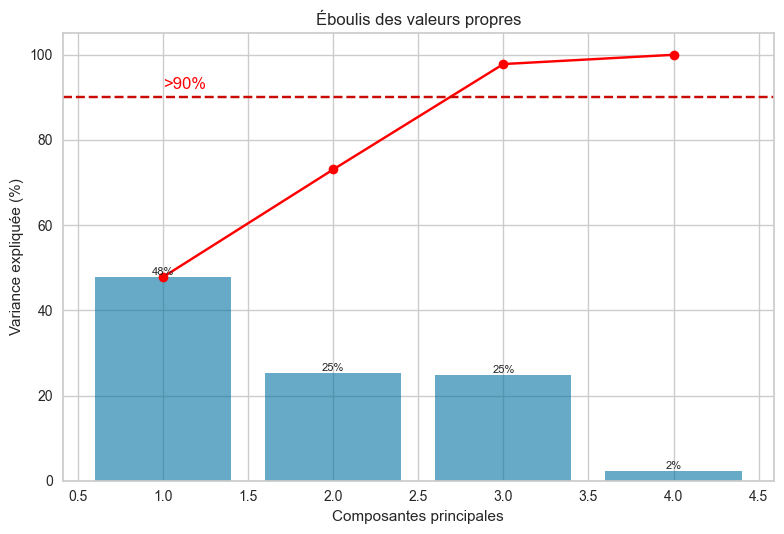

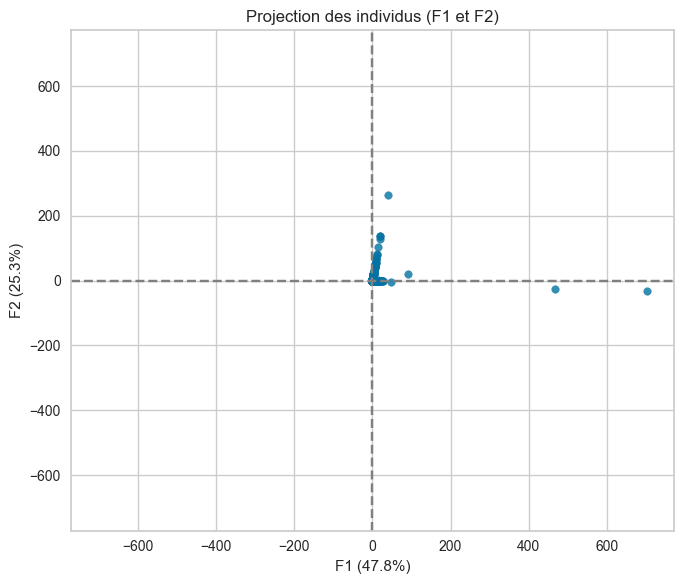

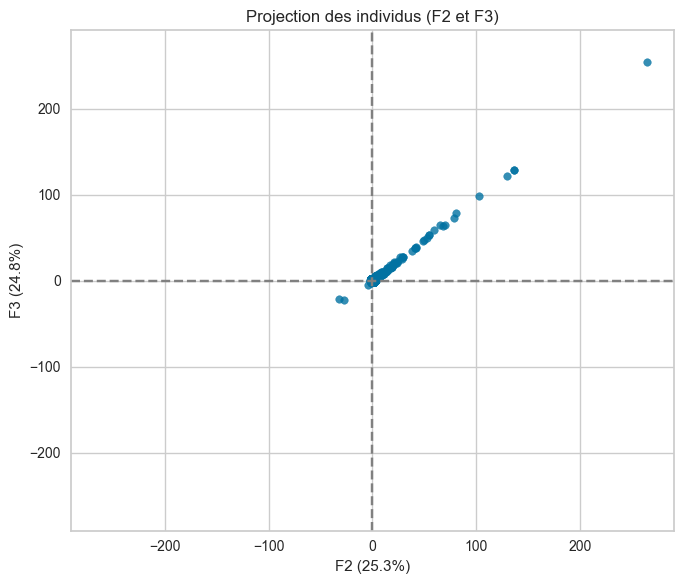

In [40]:
# Initialisation et calcul de l'ACP
pca = PCA(random_state=1)
projected = pca.fit_transform(base)

# Affichage de l'éboulis des valeurs propres
display_scree_plot(pca)
plt.show()

# Affichage des plans factoriels
axes_to_display = [(0,1), (1,2), (2,3), (3,4), (4,5), (5,6), (6,7)]
display_factorial_planes(
    X_projected=projected,
    pca=pca,
    axis_ranks=[(0,1), (1,2)],
    labels=None,
    illustrative_var=None,  
    colors=None,
    alpha=0.8,
    size=30
)


In [42]:
cumulative_variance = pca.explained_variance_ratio_.cumsum()
print(f'Variance expliquée dans les 3 premières composantes principales : {cumulative_variance[3]}')


Variance expliquée dans les 3 premières composantes principales : 1.0


In [43]:
# Génération automatique des noms PC1 à PC3
pc_names = [f"PC{i+1}" for i in range(3)]

# Création d'un DataFrame avec les composantes principales
base_pca = pd.DataFrame(projected[:, :3], columns=pc_names, index=base.index)


In [44]:
base_pca

,PC1,PC2,PC3
InvoiceNo,,,
536365,-0.058381,-1.047757,1.061531
536365,-0.044571,-1.020462,1.087884
536365,-0.034699,-1.042046,1.067317
536365,-0.044571,-1.020462,1.087884
536365,-0.044571,-1.020462,1.087884
...,...,...,...
581587,-0.024537,0.982433,-1.172549
581587,-0.039083,1.025337,-1.131530
581587,-0.032182,1.092757,-1.066811


## Application de K-means 

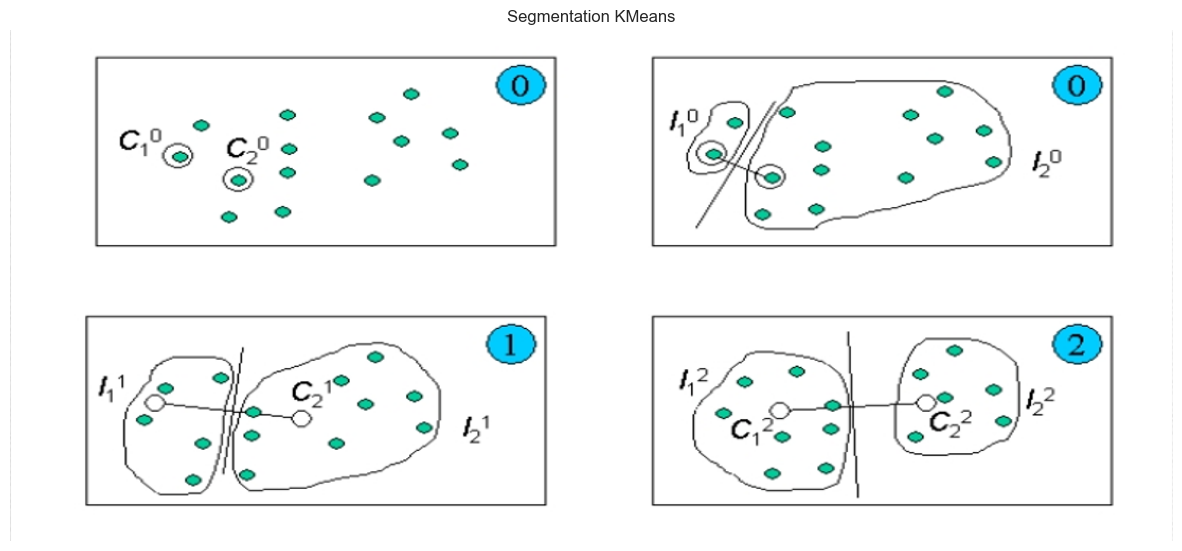

In [23]:
import matplotlib.image as mpimg
img = mpimg.imread('kmeans.png')
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.axis('off')
plt.title('Segmentation KMeans')
plt.show()


## Clustering sur 04 variables

In [90]:
base = base.reset_index()

In [91]:
# Agrégation par client
base_clients = base.groupby('CustomerID').agg(
    frequence_achat=('InvoiceNo', 'nunique'),
    montant_total=('TotalPrice', 'sum'),
    quantite_totale=('Quantity', 'sum')
).reset_index()

In [92]:
# Création d’une variable panier moyen
base_clients['panier_moyen'] = base_clients['montant_total'] / base_clients['frequence_achat']


In [93]:
# Sélection des variables numériques pour le clustering
numericalss = ['frequence_achat', 'montant_total', 'quantite_totale', 'panier_moyen']
df4 = base_clients[numericalss].copy()

In [94]:
# Standardisation
scaler = StandardScaler()
df4_scaled = scaler.fit_transform(df4)

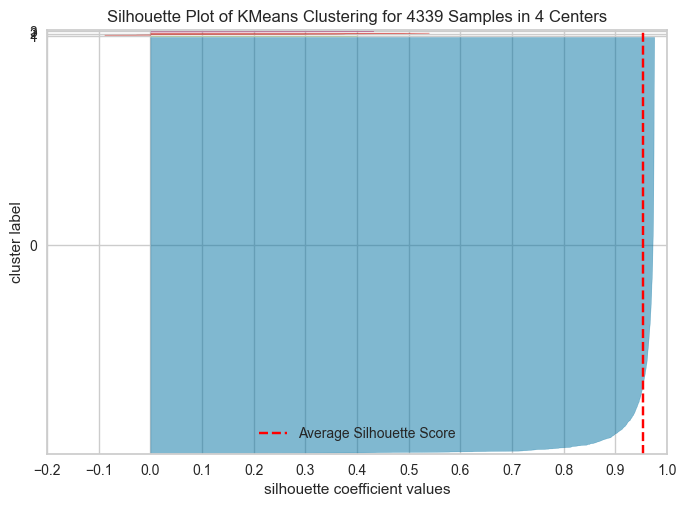

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 4339 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [96]:
# Initialisation du modèle KMeans avec k=4
model = KMeans(n_clusters=4, random_state=42)

# Création du visualiseur
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

# Entraînement
visualizer.fit(df4)

# Affichage (poof est déprécié, remplacé par show)
visualizer.show()